---
# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import plotly.express as px
import MetaTrader5 as mt5
import plotly.graph_objs as go
from math import floor
from termcolor import colored as cl
from time import sleep
from datetime import datetime, timedelta


---
# Definindo funcao para calculo do ADX, +DI e -DI

In [2]:
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()

    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1 / lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1 / lookback).mean()
    return plus_di, minus_di, adx_smooth

---
# Estabelecendo conexao com o MetaTrader

In [3]:
class MT5DataFeed(object):
    def __init__(self):
        mt5.initialize()

    def _get_ohlc(self):
        return mt5.copy_rates_from('WIN$N', mt5.TIMEFRAME_M15, datetime.now(), 2800)

    def _get_volume(self):
        return mt5.copy_ticks_range('WIN$N', 0, datetime.now(), mt5.COPY_TICKS_TRADE)['volume']

In [4]:
server = MT5DataFeed()

---
# Importando dados do MetaTrader

In [5]:
df = mt5.copy_rates_from('WIN$N', mt5.TIMEFRAME_M15, datetime.now(), 900)
df = pd.DataFrame(df)
df.time = df.time.apply(datetime.fromtimestamp) + timedelta(hours=3) # Foda


---
## Logica para o indicador (KARACATICO)


In [6]:
df['plus_di'] = pd.DataFrame(get_adx(df.high, df.low, df.close, 70)[0]).rename(columns = {0:'plus_di'})

df['minus_di'] = pd.DataFrame(get_adx(df.high, df.low, df.close, 70)[1]).rename(columns = {0: 'minus_di'})

df['adx'] = pd.DataFrame(get_adx(df.high, df.low, df.close, 70)[2]).rename(columns = {0: 'adx'})

df.dropna(inplace = True)

df['sinal_compra'] = np.where((df.shift(1).plus_di < df.shift(1).minus_di) & (df.plus_di > df.minus_di), 1, 0)

df['sinal_venda'] = np.where((df.shift(1).plus_di > df.shift(1).minus_di) & (df.plus_di < df.minus_di), 1, 0)

df[['sinal_compra', 'sinal_venda']].value_counts()

df['buy'] = np.where((df.close > df.shift(70).close) & (df.sinal_compra == 1), 1, 0)

df['sell'] = np.where((df.close < df.shift(70).close) & (df.sinal_venda == 1), 1, 0)

df = df.tail(450)

display(df[['buy', 'sell']].value_counts())

buy  sell
0    0       430
1    0        11
0    1         9
dtype: int64

---
# fig = Grafico simulando as compras, sem restrição de apenas uma por dia

----------------

In [7]:
from plotly.subplots import make_subplots

fig = make_subplots(rows = 2, cols = 1, shared_xaxes=True, vertical_spacing=0.02, row_width = [0.1, 0.4])

fig.add_trace(go.Scatter(x = df.time, 
                         y = df.plus_di, 
                         line = dict(color = 'blue', width = .7), 
                         name = '+ DI'), 
              row = 2, col = 1)

fig.add_trace(go.Scatter(x = df.time, 
                         y = df.minus_di, 
                         line = dict(color = 'red', width = .7), 
                         mode = 'lines', 
                         name = '- DI'), 
              row = 2, col = 1)

#fig.add_trace(go.Scatter(x = df.time, y = df.adx, line = dict(color = 'green', width = .7), name = 'ADX', mode = 'markers'), row = 2, col = 1)


# Candlestick
fig.add_trace(go.Candlestick(x = df.time, 
                             open = df.open, 
                             high = df.high, 
                             low = df.low, 
                             close = df.close, 
                             name = 'WIN$N',
                             ), 
                             row = 1, col = 1)

# Adicionando títulos
fig.update_layout(yaxis_title = 'WIN$N')


for i in range(len(df[df.buy == 1].time.tolist())):
    fig.add_annotation(x = df[df.buy == 1 ].time.tolist()[i], 
                       y = df[df.buy == 1].low.tolist()[i]*.9999, 
                       text = '✔️', 
                       showarrow = False, 
                       textangle = 0)

for i in range(len(df[df.sell == 1].time.tolist())):
    fig.add_annotation(x = df[df.sell == 1 ].time.tolist()[i], 
                       y = df[df.sell == 1].high.tolist()[i]*1.001, 
                       text = '⭕', 
                       showarrow = False, 
                       textangle = 0)

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=[18, 9], pattern="hour"),
        dict(bounds=["sat", "mon"]),
        #dict(values = ["2021-11-02"]),
    ])

fig.update_layout(
    autosize=True,
    #width=800,
    #height=900,
    #paper_bgcolor='rgba(0,0,0,0)',
    #plot_bgcolor='rgba(0,0,0,0)',
    xaxis_rangeslider_visible=False,
    legend=dict(
    yanchor="bottom",
    y=0.25,
    xanchor="right",
    x=0.99,    
    ),
    hovermode = 'x unified')

fig.update_yaxes(showgrid=False, 
                 zeroline=False, 
                 showticklabels=False,
                 showspikes=True, 
                 spikemode='across', 
                 spikesnap='hovered data', #['cursor', 'hovered data','data']
                 showline=True, 
                 spikedash="longdashdot") #["solid", "dot", "dash", "longdash", "dashdot", "longdashdot"]


fig.update_xaxes(showgrid=True, 
                 zeroline=False, 
                 rangeslider_visible=False, #nao sei o que faz, mas fica estranho quando usa como True
                 showticklabels=True, #mostrar os valores nas linhas
                 showspikes=True, #mostrar as linhas
                 spikemode='across', #['toaxis', 'across', 'marker']
                 spikesnap='hovered data', #['cursor', 'hovered data','data']
                 showline=True, 
                 spikedash='longdashdot') #["solid", "dot", "dash", "longdash", "dashdot", "longdashdot"]

#fig.update_layout(hoverdistance=0)

fig.update_traces(xaxis='x', )

display(df[['buy', 'sell']].value_counts())

buy  sell
0    0       430
1    0        11
0    1         9
dtype: int64

---
# Lógica para comprar uma vez ao dia

Buy

In [8]:
def get_list(x,m) : return list(zip(*(x[i:] for i in range(m))))
df['teste'] = pd.Series(get_list(df['buy'],38), index=df.index[38 - 1:])
df['teste_2'] = pd.Series(get_list(df.time.dt.day,38), index=df.index[38 - 1:])


df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)


obj = {'r_1':[]}

df.reset_index(drop = True, inplace = True)

for z in range(len(df)):
    obj['r_1'].append(sum([1 if ( [1 if df.teste_2[z][-1] == df.teste_2[z][i] else 0 for i in range(len(df.teste_2[z]))][i] == 1) & (df.teste[z][i] == 1) else 0 for i in range(38)]))
    
    
df = df.reset_index().merge(pd.DataFrame(obj).reset_index(), how = 'left', on = 'index').drop(columns = 'index')


df['compra real'] = np.where(df.r_1 > 1, 0, np.where(df.r_1 == 0, 0 , np.where(df.buy == 1, 1, 0)))


df.drop(columns = ['teste', 'teste_2', 'r_1'], inplace = True)

Sell

In [9]:
df['teste'] = pd.Series(get_list(df['sell'],38), index=df.index[38 - 1:])
df['teste_2'] = pd.Series(get_list(df.time.dt.day,38), index=df.index[38 - 1:])

df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)


obj = {'r_1':[]}

df.reset_index(drop = True, inplace = True)

for z in range(len(df)):
    obj['r_1'].append(sum([1 if ( [1 if df.teste_2[z][-1] == df.teste_2[z][i] else 0 for i in range(len(df.teste_2[z]))][i] == 1) & (df.teste[z][i] == 1) else 0 for i in range(38)]))
    
    
df = df.reset_index().merge(pd.DataFrame(obj).reset_index(), how = 'left', on = 'index').drop(columns = 'index')


df['venda real'] = np.where(df.r_1 > 1, 0, np.where(df.r_1 == 0, 0 , np.where(df.sell == 1, 1, 0)))


df.drop(columns = ['teste', 'teste_2', 'r_1'], inplace = True)


In [10]:
display(df[df.buy == 1])
print("\n\n")
display(df[df.sell == 1])

,time,open,high,low,close,tick_volume,spread,real_volume,plus_di,minus_di,adx,sinal_compra,sinal_venda,buy,sell,compra real,venda real
49,2021-11-01 16:00:00,106445.0,106850.0,106420.0,106770.0,136086,5,479301,21.299044,20.500608,6.010696,1,0,1,0,1,0
68,2021-11-03 11:45:00,106265.0,106590.0,106175.0,106185.0,206382,5,707576,24.216662,24.209957,5.601659,1,0,1,0,1,0
71,2021-11-03 12:30:00,106140.0,107285.0,106090.0,107265.0,308986,5,1062360,26.258777,23.820437,5.409888,1,0,1,0,0,0
84,2021-11-03 15:45:00,106035.0,107545.0,106005.0,107030.0,353819,5,1145874,29.039681,24.766422,4.974996,1,0,1,0,0,0
134,2021-11-05 10:15:00,105390.0,105735.0,105380.0,105700.0,211100,5,680431,22.005026,21.421080,5.340441,1,0,1,0,1,0
173,2021-11-08 11:00:00,105465.0,105865.0,105435.0,105830.0,227485,5,680279,23.980235,23.246429,4.119016,1,0,1,0,1,0
184,2021-11-08 13:45:00,105440.0,105995.0,105325.0,105875.0,189504,5,661867,23.809420,23.132148,3.876926,1,0,1,0,0,0
195,2021-11-08 16:30:00,105490.0,105640.0,105415.0,105595.0,123458,5,421182,23.647382,23.407037,3.553177,1,0,1,0,0,0
237,2021-11-09 17:30:00,106030.0,106595.0,105920.0,106540.0,158305,5,484851,24.077216,23.094479,4.451473,1,0,1,0,1,0
249,2021-11-10 11:00:00,106540.0,106800.0,106510.0,106735.0,217424,5,710126,24.252922,24.100394,4.107329,1,0,1,0,1,0


,time,open,high,low,close,tick_volume,spread,real_volume,plus_di,minus_di,adx,sinal_compra,sinal_venda,buy,sell,compra real,venda real
48,2021-11-01 15:45:00,106285.0,106565.0,106235.0,106445.0,145354,5,519613,20.756090,20.782766,6.096556,0,1,0,1,0,1
99,2021-11-04 10:30:00,105860.0,106055.0,105560.0,105575.0,312547,5,1064305,25.139015,25.260753,5.290417,0,1,0,1,0,1
139,2021-11-05 11:30:00,105395.0,105575.0,105135.0,105415.0,234068,5,803371,22.185239,22.269468,5.194160,0,1,0,1,0,1
162,2021-11-05 17:15:00,105400.0,105520.0,105220.0,105285.0,68152,5,207769,22.435652,22.736903,4.261001,0,1,0,1,0,0
241,2021-11-10 09:00:00,105740.0,105760.0,105260.0,105330.0,179440,5,441283,22.800757,25.191857,4.296536,0,1,0,1,0,1
327,2021-11-12 11:30:00,107000.0,107045.0,106650.0,106825.0,58132,0,842672,22.094793,22.223568,8.405485,0,1,0,1,0,1


In [23]:
df.groupby(df.time.dt.day).agg({'low': 'count'}).low.max()

38

---
# fig2 = Grafico com uma compra ao dia

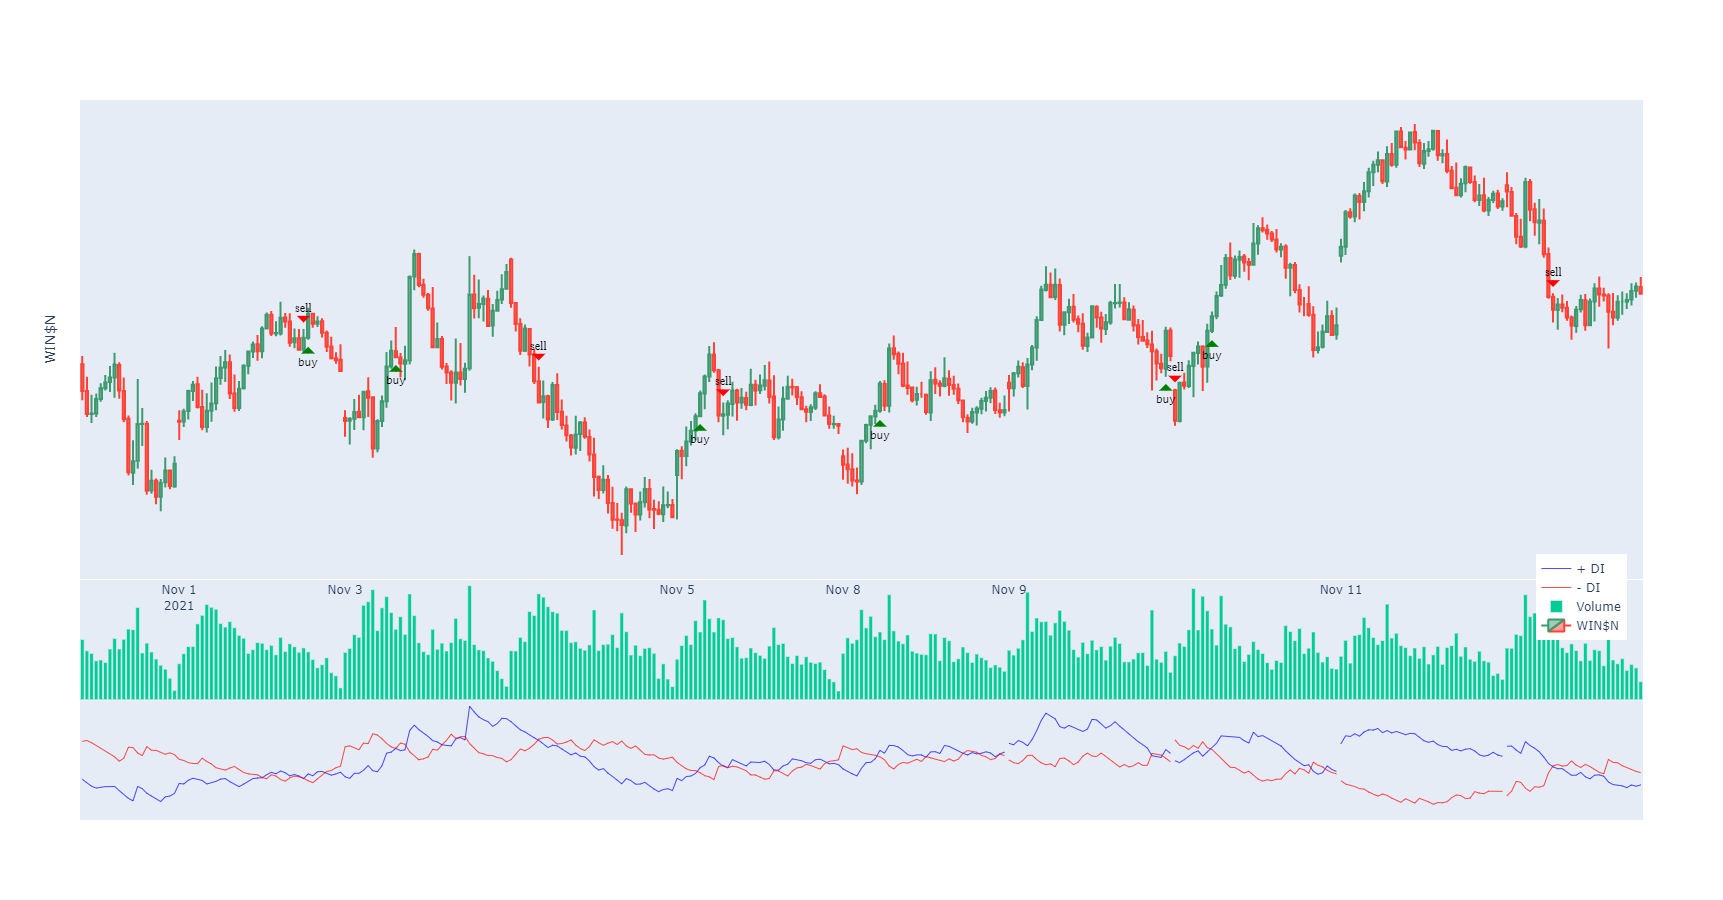

In [14]:
from plotly.subplots import make_subplots

fig2 = make_subplots(rows = 3, cols = 1, shared_xaxes=True, vertical_spacing=0.001, row_width = [0.1, 0.1, 0.4])

fig2.add_trace(go.Scatter(x = df.time, 
                         y = df.plus_di, 
                         line = dict(color = 'blue', width = .7), 
                         name = '+ DI'), 
              row = 3, col = 1)

fig2.add_trace(go.Scatter(x = df.time, 
                         y = df.minus_di, 
                         line = dict(color = 'red', width = .7), 
                         mode = 'lines', 
                         name = '- DI'), 
              row = 3, col = 1)

#fig.add_trace(go.Scatter(x = df.time, y = df.adx, line = dict(color = 'green', width = .7), name = 'ADX', mode = 'markers'), row = 2, col = 1)

fig2.add_trace(go.Bar(x=df.time, y=df.real_volume, name = 'Volume'), row = 2, col = 1)


# Candlestick
fig2.add_trace(go.Candlestick(x = df.time, 
                             open = df.open, 
                             high = df.high, 
                             low = df.low, 
                             close = df.close, 
                             name = 'WIN$N',
                             ), 
                             row = 1, col = 1)






# Adicionando títulos
fig2.update_layout(yaxis_title = 'WIN$N')

for i in range(len(df[df['compra real'] == 1].time.tolist())):
    fig2.add_annotation(x = df[df['compra real'] == 1 ].time.tolist()[i], 
                        y = df[df['compra real'] == 1].low.tolist()[i]*.9991,
                        #xref="datas",
                        #yref="prices",
                        text = "buy", #'↑'
                        font=dict(
                            family="monospace",
                            size=12,
                            color="black"
                            ),
                        align="center",
                        showarrow = True,
                        textangle = 0,
                        arrowhead = 1,
                        arrowsize = 1.5,
                        arrowwidth = 1.5,
                        arrowcolor = "green",
                        ax=0,
                        ay=15,
                       )

for i in range(len(df[df['venda real'] == 1].time.tolist())):
    fig2.add_annotation(x = df[df['venda real'] == 1 ].time.tolist()[i], 
                        y = df[df['venda real'] == 1].high.tolist()[i]*1.0008,
                        #xref="datas",
                        #yref="prices",
                        text = 'sell', #'↓'
                        font=dict(
                            family="Open Sans",
                            size=12,
                            color="black"
                            ),
                        align="center",
                        showarrow = True,
                        textangle = 0,
                        arrowhead = 1,
                        arrowsize = 1.5,
                        arrowwidth = 1.5,
                        arrowcolor = "red",
                        ax=0,
                        ay=-15,
                       )

fig2.update_xaxes(
    rangebreaks=[
        dict(bounds=[18, 9], pattern="hour"),
        dict(bounds=["sat", "mon"]),
        dict(values = [pd.Timestamp('2021-11-02 9:00:00')]),
        dict(values = [pd.Timestamp('2021-11-15 9:00:00')]),
        dict(values = [pd.Timestamp('2021-11-15 18:00:00')])
    ])

fig2.update_layout(
    autosize=True,
    #width=800,
    height=900,
    #paper_bgcolor='rgba(0,0,0,0)',
    #plot_bgcolor='rgba(0,0,0,0)',
    xaxis_rangeslider_visible=False,
    legend=dict(
    yanchor="bottom",
    y=0.25,
    xanchor="right",
    x=0.99,    
    ),
    hovermode = 'x unified')

fig2.update_yaxes(showgrid=False, 
                 zeroline=False, 
                 showticklabels=False,
                 showspikes=True, 
                 spikemode='across', 
                 spikesnap='hovered data', #['cursor', 'hovered data','data']
                 showline=True, 
                 spikedash="longdashdot") #["solid", "dot", "dash", "longdash", "dashdot", "longdashdot"]


fig2.update_xaxes(showgrid=False, 
                 zeroline=False, 
                 rangeslider_visible=False, #nao sei o que faz, mas fica estranho quando usa como True
                 showticklabels=True, #mostrar os valores nas linhas
                 showspikes=True, #mostrar as linhas
                 spikemode='across', #['toaxis', 'across', 'marker']
                 spikesnap='hovered data', #['cursor', 'hovered data','data']
                 showline=True, 
                 spikedash='longdashdot') #["solid", "dot", "dash", "longdash", "dashdot", "longdashdot"]

#fig.update_layout(hoverdistance=0)

fig2.update_traces(xaxis='x', )

fig2.show()

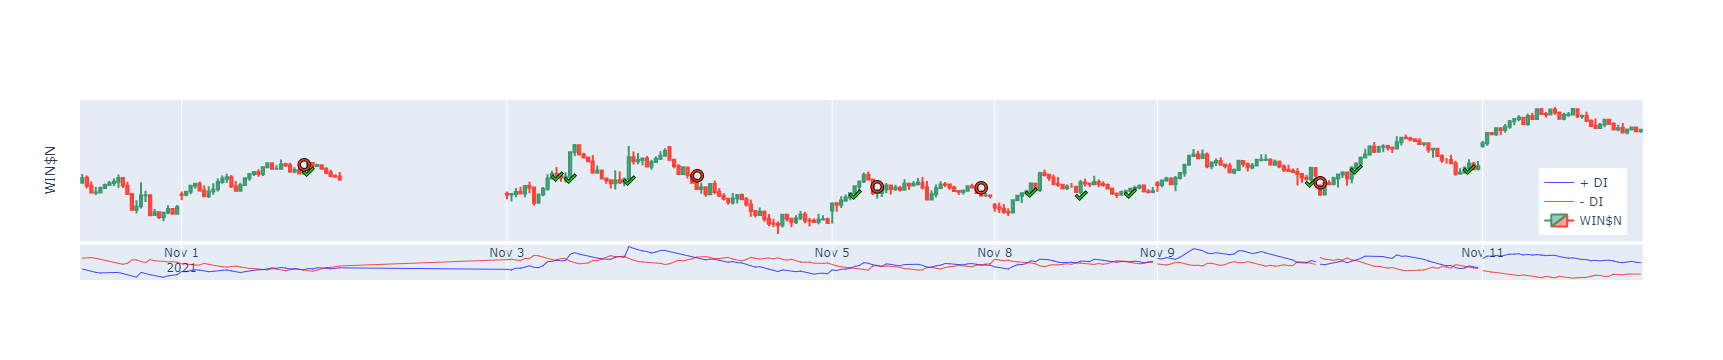

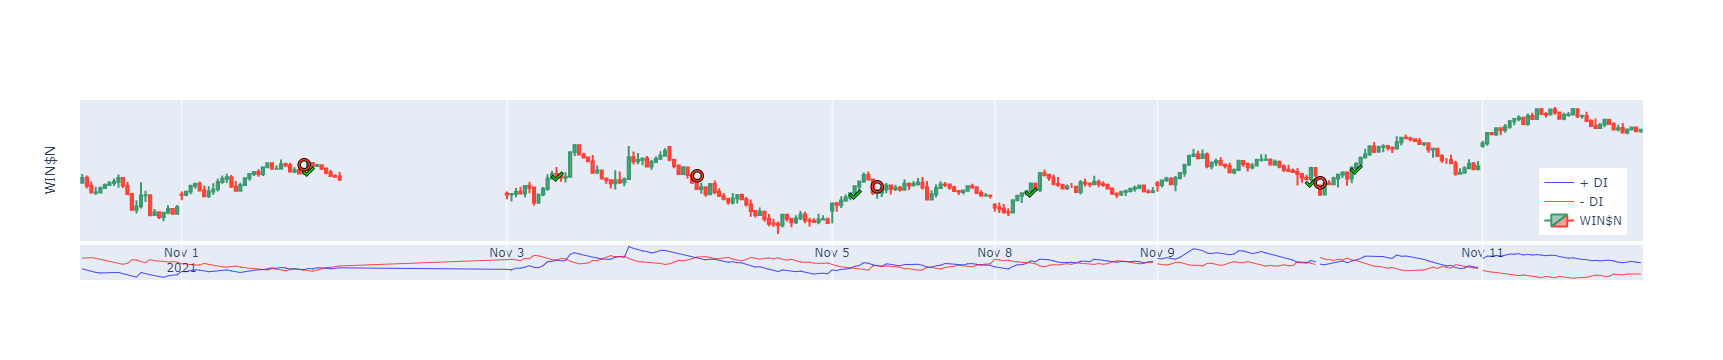

In [32]:
fig.show()
fig2.show()

In [52]:
df.iloc[94:,]

,time,open,high,low,close,tick_volume,spread,real_volume,plus_di,minus_di,...,sinal_compra,sinal_venda,buy,sell,compra real,venda real,take_profit,stop_loss,take_profit_s,stop_loss_s
94,2021-11-04 09:00:00,107500.0,107525.0,106850.0,106915.0,192842,5,490646,27.260931,22.929494,...,0,0,0,0,0,0,-,-,-,-
95,2021-11-04 09:15:00,106915.0,106915.0,106530.0,106630.0,151676,5,488765,26.773098,23.537854,...,0,0,0,0,0,0,-,-,-,-
96,2021-11-04 09:30:00,106630.0,106710.0,106215.0,106270.0,192504,5,626146,26.331930,24.150530,...,0,0,0,0,0,0,-,-,-,-
97,2021-11-04 09:45:00,106270.0,106625.0,106255.0,106570.0,182254,5,584034,26.100811,23.938558,...,0,0,0,0,0,0,-,-,-,-
98,2021-11-04 10:00:00,106565.0,106570.0,106060.0,106220.0,282518,5,886546,25.744366,24.234879,...,0,0,0,0,0,0,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,2021-11-11 17:15:00,108300.0,108425.0,108260.0,108385.0,77149,5,242490,23.768694,19.314954,...,0,0,0,0,0,0,-,-,-,-
314,2021-11-11 17:30:00,108390.0,108440.0,108180.0,108215.0,84234,5,263434,23.455496,19.323276,...,0,0,0,0,0,0,-,-,-,-
315,2021-11-11 17:45:00,108215.0,108325.0,108155.0,108285.0,59565,5,202988,23.305597,19.297460,...,0,0,0,0,0,0,-,-,-,-
316,2021-11-11 18:00:00,108285.0,108310.0,108190.0,108250.0,40203,5,128801,23.421040,19.393049,...,0,0,0,0,0,0,-,-,-,-


In [16]:

df['take_profit'] = np.where(df.buy == 1, df.close + 1500, "-")
df['stop_loss'] = np.where(df.buy == 1, df.close - 500, "-")
df['take_profit_s'] = np.where(df.buy == 1, df.close - 1500, "-")
df['stop_loss_s'] = np.where(df.buy == 1, df.close + 500, "-")


In [17]:
df[df['compra real'] == 1]

,time,open,high,low,close,tick_volume,spread,real_volume,plus_di,minus_di,...,sinal_compra,sinal_venda,buy,sell,compra real,venda real,take_profit,stop_loss,take_profit_s,stop_loss_s
124,2021-11-01 16:00:00,106445.0,106850.0,106420.0,106770.0,136086,5,479301,21.298396,20.499191,...,1,0,1,0,1,0,108270.0,106270.0,105270.0,107270.0
143,2021-11-03 11:45:00,106265.0,106590.0,106175.0,106185.0,206382,5,707576,24.216095,24.208624,...,1,0,1,0,1,0,107685.0,105685.0,104685.0,106685.0
209,2021-11-05 10:15:00,105390.0,105735.0,105380.0,105700.0,211100,5,680431,22.004829,21.420638,...,1,0,1,0,1,0,107200.0,105200.0,104200.0,106200.0
248,2021-11-08 11:00:00,105465.0,105865.0,105435.0,105830.0,227485,5,680279,23.980149,23.246180,...,1,0,1,0,1,0,107330.0,105330.0,104330.0,106330.0
312,2021-11-09 17:30:00,106030.0,106595.0,105920.0,106540.0,158305,5,484851,24.077207,23.094399,...,1,0,1,0,1,0,108040.0,106040.0,105040.0,107040.0
324,2021-11-10 11:00:00,106540.0,106800.0,106510.0,106735.0,217424,5,710126,24.252911,24.100317,...,1,0,1,0,1,0,108235.0,106235.0,105235.0,107235.0
